Initial solution: 13498.348890900861
Best objective: 15177.683575234016


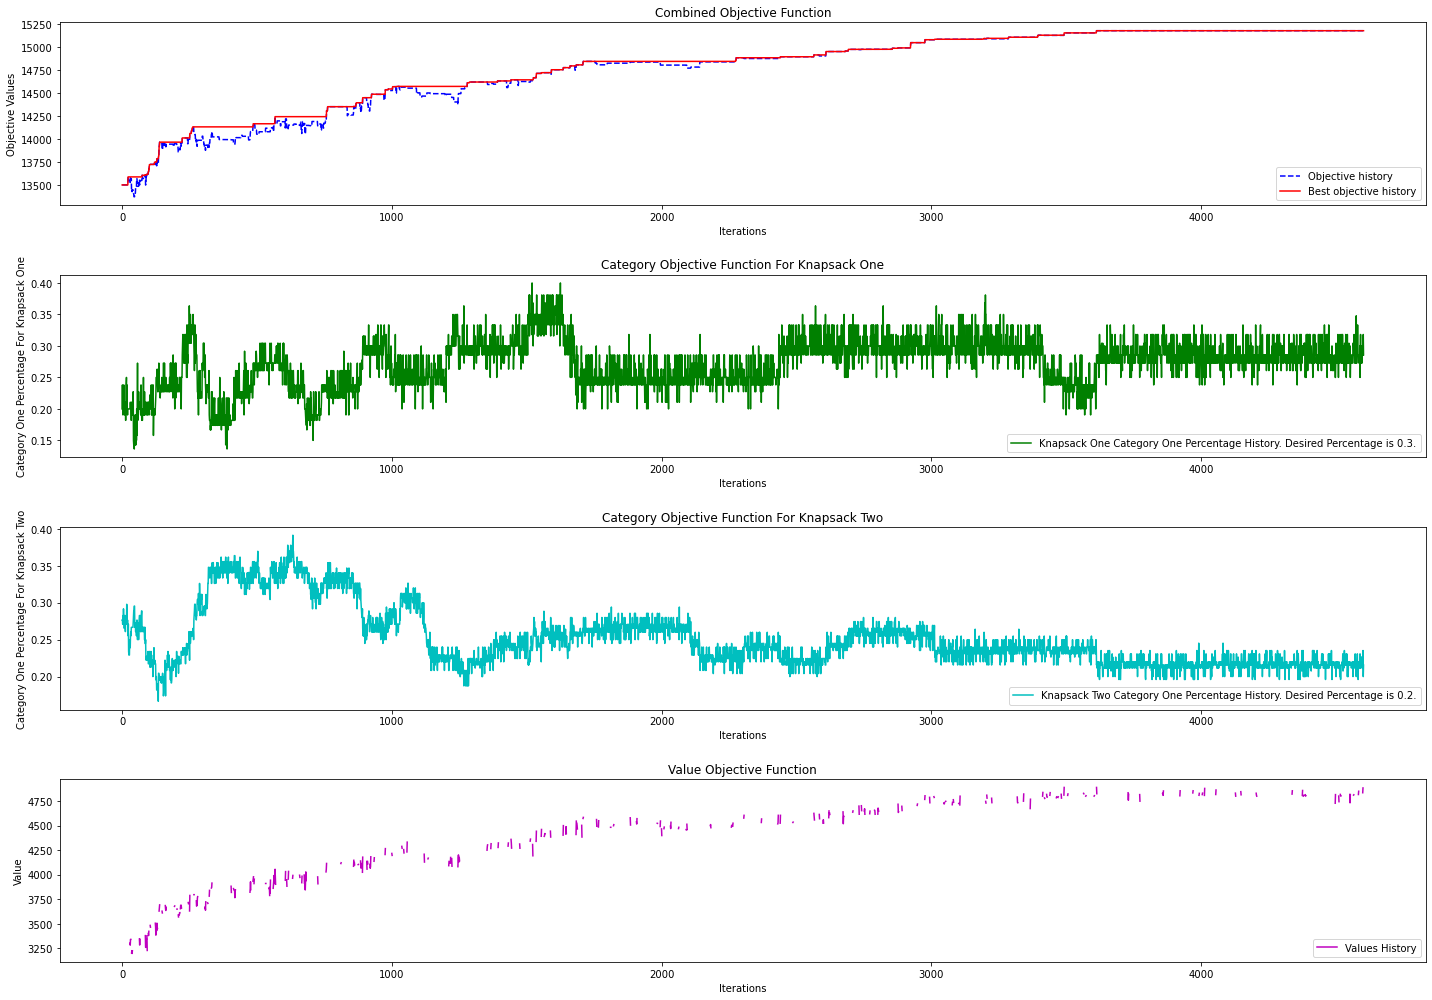

In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt

amount_of_objects = 200

# 200 weights between 100-200
weights = np.random.randint(100,200, amount_of_objects)

# 200 values between 10-90 
values = np.random.randint(10,90, amount_of_objects)

object_indices = range(amount_of_objects)

categories = np.random.choice([1,2], size=amount_of_objects, p= [0.3, 0.7])

knapsack_capacity_one = 3000
knapsack_capacity_two = 7000
knapsack_capacity = {1:knapsack_capacity_one,2:knapsack_capacity_two}


def categories_objective_function(solution,category_one_desired_percentage_for_knapsack_one,category_one_desired_percentage_for_knapsack_two):

    # takes dot product to find amount in each category for each knapsack
    # (the *1 is to turn a boolean array into an integer array)
    category_one_knapsack_one = np.dot((solution==1)*1,categories==1)
    category_one_knapsack_two = np.dot((solution==2)*1,categories==1)
    category_two_knapsack_one = np.dot((solution==1)*1,categories==2)
    category_two_knapsack_two = np.dot((solution==2)*1,categories==2)
    
    # gets the category percentage for each knapsack
    category_one_percentage_knapsack_one = category_one_knapsack_one/(category_one_knapsack_one+category_two_knapsack_one)
    category_one_percentage_knapsack_two = category_one_knapsack_two/(category_one_knapsack_two+category_two_knapsack_two)
    
    #finds the difference between desired percentage and gotten percentage for knapsack one
    knapsack_one_difference = category_one_percentage_knapsack_one - category_one_desired_percentage_for_knapsack_one
    knapsack_one_abs_difference = np.square(knapsack_one_difference)
    knapsack_one_evaluation = 1 - knapsack_one_abs_difference
    
     #finds the difference between desired percentage and gotten percentage for knapsack two
    knapsack_two_difference = category_one_percentage_knapsack_two - category_one_desired_percentage_for_knapsack_two
    knapsack_two_abs_difference = np.square(knapsack_two_difference)
    knapsack_two_evaluation = 1 - knapsack_two_abs_difference

    #returns values
    return category_one_percentage_knapsack_one, category_one_percentage_knapsack_two, knapsack_one_evaluation, knapsack_two_evaluation

def value_objective_function(solution):
    #evaluates values using dot product
    total_weight_knapsack_one = np.dot(solution == 1,weights)
    total_weight_knapsack_two = np.dot(solution == 2,weights)
    
    if total_weight_knapsack_one>knapsack_capacity_one or total_weight_knapsack_two>knapsack_capacity_two:
        return float("-inf")
    
    return np.dot(solution==1,values) + np.dot(solution==2,values)
    

def combined_objective_function(solution, category_weighting_factor, category_one_desired_percentage_for_knapsack_one, category_one_desired_percentage_for_knapsack_two):
    
    value_evaluation = value_objective_function(solution)
    
    category_one_percentage_knapsack_one, category_one_percentage_knapsack_two, knapsack_one_evaluation, knapsack_two_evaluation =categories_objective_function(solution,category_one_desired_percentage_for_knapsack_one,category_one_desired_percentage_for_knapsack_two)
    
    #get overall category one evaluation by averaging knapsack one evaluation and knapsack two evaluation
    objf_cat_eval = (knapsack_one_evaluation + knapsack_two_evaluation)/2
    
    # chose this way so that: 
    # values and amount of objects can scale without affecting category eval
    # disjoint from value_objective_function
    # standardized for all solutions (as mean and amount of objects constant)
    category_evaluation = objf_cat_eval * amount_of_objects * np.mean(values) 
    
    total_evaluation = value_evaluation + category_weighting_factor*category_evaluation
    
    return value_evaluation, category_one_percentage_knapsack_one, category_one_percentage_knapsack_two, total_evaluation


def get_neighbour(current_solution):
    
    chance_of_using_choice_1 = 0.6
    can_use_choice_2 = 0 in current_solution and 1 in current_solution
    if np.random.random() < chance_of_using_choice_1 or not can_use_choice_2:
        neighbourhood_func = neighbour_choice_1
    else:
        neighbourhood_func = neighbour_choice_2
        
    return neighbourhood_func(current_solution)

# randomized number out of 0,1,2
# choose one out of two choices 
# (current don't count)
def neighbour_choice_1(current_solution):
    i = random.choice(object_indices)
    neighbour_solution = np.copy(current_solution)
    
    random_number = random.choice([c for c in [0,1,2] if c != neighbour_solution[i]])

    neighbour_solution[i] = random_number
   
    return neighbour_solution

# same as above but for both
def neighbour_choice_2(current_solution):
    used_i = 0
    used_j = 0
    while used_i == used_j:
        i = random.choice(object_indices)
        j = random.choice(object_indices)
        used_i = current_solution[i]
        used_j = current_solution[j]
        
    neighbour_solution = np.copy(current_solution)
   
    random_number_first_slot = random.choice([c for c in [0,1,2] if c != neighbour_solution[i]])
    
    random_number_second_slot = random.choice([c for c in [0,1,2] if c != neighbour_solution[j]])
    
    neighbour_solution[i] = random_number_first_slot
    neighbour_solution[j] = random_number_second_slot
   
    return neighbour_solution

def random_initial_solution():
  
    total_weight_one = 0
    total_weight_two = 0
    solution = np.zeros(amount_of_objects)  
    
    # function to check capacity of knapsack
    # returns available assessment of each knapsack for a weight given
    def check_capacity(weight):
        one = False
        two = False
        if weights[index] <= knapsack_capacity_one - total_weight_one:
            one = True
        if weights[index] <= knapsack_capacity_two - total_weight_two:
            two = True
        return one, two 
    
    for index in np.random.permutation(object_indices):
        
        #randomly chooses a knapsack 
        choice_of_knapsack = random.choice([1,2])
        
        # assess if weight can fit into knapsack (one or two)
        can_fit_knapsack_one, can_fit_knapsack_two = check_capacity(weights[index])
        
        #if random choice is knapsack one 
        if choice_of_knapsack == 1:
            #if can fit into knapsack one, put it there
            if can_fit_knapsack_one:
                solution[index] = 1
                total_weight_one += weights[index]
            #else if cannot fit into knapsack one, but can in knapsack two, then put it there
            elif can_fit_knapsack_two:
                solution[index] = 2
                total_weight_two += weights[index]
        
        #if random choice is knapsack two
        if choice_of_knapsack == 2:
            #if can fit into knapsack two, put it there
            if can_fit_knapsack_two:
                solution[index] = 2
                total_weight_two += weights[index]
            #else if cannot fit into knapsack two, but can in knapsack one, then put it there
            elif can_fit_knapsack_one:
                solution[index] = 1
                total_weight_one += weights[index]
        
    return solution



def SA_knapsack(initial_temperature, cooling_rate, category_weighting_factor,category_one_desired_percentage_for_knapsack_one, category_one_desired_percentage_for_knapsack_two): 

    # category evaluation for knapsack one
    category_history_knapsack_one = []
    
    # category evaluation for knapsack two
    category_history_knapsack_two = []
    
    # value evaluation 
    value_history = []
    
    # items chosen
    solution_history = []
    
    # objective evaluated from combination of category and value 
    objective_history = []
    best_objective_history = []
    
    # initialize values for best objective and best solution
    best_objective = float("-inf")
    best_solution = None
    
    current_solution = random_initial_solution()
    value_evaluation, category_one_percentage_knapsack_one, category_one_percentage_knapsack_two, current_objective = \
        combined_objective_function(current_solution,category_weighting_factor,
                                    category_one_desired_percentage_for_knapsack_one, category_one_desired_percentage_for_knapsack_two)
    print(f'Initial solution: {current_objective}')
    
    best_solution = current_solution
    best_objective = current_objective

    def add_history(current_solution, current_objective, best_objective, category_one_percentage_knapsack_one, category_one_percentage_knapsack_two,value_evaluation):
        solution_history.append(current_solution)
        objective_history.append(current_objective)
        best_objective_history.append(best_objective)
        category_history_knapsack_one.append(category_one_percentage_knapsack_one) 
        category_history_knapsack_two.append(category_one_percentage_knapsack_two)
        value_history.append(value_evaluation)
    
    add_history(current_solution, current_objective, best_objective,category_one_percentage_knapsack_one,category_one_percentage_knapsack_two,value_evaluation)
    
    current_temperature = initial_temperature
    
    while current_temperature > 1:
        
        # get new solution utilizing neighbour function
        new_solution = get_neighbour(current_solution)
        
        # get objective value of that new solution utilizing objective function
        value_evaluation, category_one_percentage_knapsack_one, category_one_percentage_knapsack_two, objective_new_solution = combined_objective_function(new_solution, category_weighting_factor, 
                                                             category_one_desired_percentage_for_knapsack_one, category_one_desired_percentage_for_knapsack_two) 
        # calculate difference in objective values between current and new
        diff = objective_new_solution-current_objective
        
        # as time goes on
        # values will shift towards the left of the exponential curve
        # due to the x = diff/T becoming smaller
        # due to the diff becoming smaller
        # even though the divisor T becomes smaller
        if np.exp(diff/current_temperature) > np.random.rand():
            current_objective = objective_new_solution
            current_solution = new_solution
            if current_objective > best_objective:
                best_objective = current_objective
                best_solution = current_solution 
        
        # reduce temperature
        current_temperature *= (1-cooling_rate)
        #print(f"temp {current_temperature}, obj {current_objective}")
        
        add_history(current_solution, current_objective, best_objective,category_one_percentage_knapsack_one,category_one_percentage_knapsack_two,value_evaluation)
       
    print(f'Best objective: {best_objective}')
 
    return best_solution, solution_history, objective_history, best_objective_history, \
           category_history_knapsack_one,category_history_knapsack_two, \
           value_history,category_one_desired_percentage_for_knapsack_one,category_one_desired_percentage_for_knapsack_two

# utilize simulated annealing function
best_solution, solution_history, objective_history, best_objective_history, \
category_history_knapsack_one,category_history_knapsack_two, value_history, \
category_one_desired_percentage_for_knapsack_one, category_one_desired_percentage_for_knapsack_two = \
    SA_knapsack(initial_temperature=100, cooling_rate=0.001,
                category_weighting_factor=1, 
                category_one_desired_percentage_for_knapsack_one=0.3, category_one_desired_percentage_for_knapsack_two=0.2)

# graph 
# overall objective
# categories percentage for knapsack one
# categories percentage for knapsack two
# overall values 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(20,14))

ax1.plot(objective_history,"b--",label = "Objective history")
ax1.plot(best_objective_history,"r-",label = "Best objective history")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Objective Values")
ax1.legend(loc='lower right')
ax1.set_title("Combined Objective Function")

ax2.plot(category_history_knapsack_one,"g-", label = f'Knapsack One Category One Percentage History. '
                                        f'Desired Percentage is {category_one_desired_percentage_for_knapsack_one}.')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Category One Percentage For Knapsack One")
ax2.legend(loc = "lower right")
ax2.set_title("Category Objective Function For Knapsack One")

ax3.plot(category_history_knapsack_two,"c-", label = f'Knapsack Two Category One Percentage History. '
                                        f'Desired Percentage is {category_one_desired_percentage_for_knapsack_two}.')
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Category One Percentage For Knapsack Two")
ax3.legend(loc = "lower right")
ax3.set_title("Category Objective Function For Knapsack Two")

ax4.plot(value_history,"m-", label = "Values History")
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Value")
ax4.legend(loc = "lower right")
ax4.set_title("Value Objective Function")

fig.tight_layout()
